In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
import numpy as np

from visdom import Visdom

In [2]:
BATCH_SIZE=200
LEARNING_RATE=0.01
EPOCHS=10  
# EPOCHS=20

PATH_DATASET_MNIST = '/mnt/hgfs/C06N01/workspace/data'
DOWNLOAD_MNIST = True

WEIGHT_DECAY = 0.001
MOMENTUM = 0.05

In [3]:
if not(os.path.exists(PATH_DATASET_MNIST)) or not os.listdir(PATH_DATASET_MNIST):
    DOWNLOAD_MNIST = True

# =================== Define data source ===================
train_data = torchvision.datasets.MNIST(
    root = PATH_DATASET_MNIST,
    train=True, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        #transforms.Normalize((0.1307,), (0.3081,))
    ]),
    download=DOWNLOAD_MNIST,
)

train_data, validation_data = torch.utils.data.random_split(train_data, [50000, 10000])

test_data = torchvision.datasets.MNIST(
    root = PATH_DATASET_MNIST,
    train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        #transforms.Normalize((0.1307,), (0.3081,))
    ]),
    download=DOWNLOAD_MNIST,
)

# =================== Define data loader ===================
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
print("#train_data: {}, #train_batches: {}".format(len(train_data), len(train_dataloader)))
print("#validation_data: {}, #validation_batches: {}".format(len(validation_data), len(validation_dataloader)))
print("#test_data: {}, #test_batches: {}".format(len(test_data), len(test_dataloader)))

#train_data: 50000, #train_batches: 250
#validation_data: 10000, #validation_batches: 50
#test_data: 10000, #test_batches: 50


An example of train data


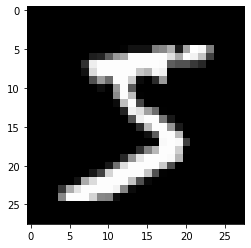

An example of validation data


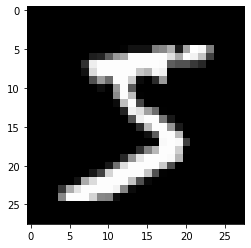

In [5]:
print("An example of train data")
plt.imshow(train_data.dataset.data[0], cmap="gray")
plt.show()

print("An example of validation data")
plt.imshow(validation_data.dataset.data[0], cmap="gray")
plt.show()

#### NN01

In [6]:
# NN(784, 200, 200, 10)

class MLP(nn.Module):
    
    # =================== Define MLP structure ===================
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 200)
            , nn.Dropout(0.7)             ##
            , nn.LeakyReLU(inplace=True)
            , nn.Linear(200, 200)
            , nn.Dropout(0.5)             ##
            , nn.LeakyReLU(inplace=True)
            , nn.Linear(200, 10)
            , nn.LeakyReLU(inplace=True)
        )
    
    # =================== Define forward method ===================
    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
# =================== Config GPU ===================
device = torch.device("cpu")
# device = torch.device("cuda:0")

mlp = MLP().to(device)  # calculate model on gpu
print(mlp)

# =================== Define loss function and optimizer ===================
cross_entropy_loss = nn.CrossEntropyLoss().to(device)  
optimizer = optim.SGD(mlp.parameters()
                      , lr=LEARNING_RATE
                      #, momentum=MOMENTUM
                      #, weight_decay=WEIGHT_DECAY
                     )  


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  ##

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=200, out_features=10, bias=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
  )
)


In [9]:
# =================== Config Visdom ===================
viz = Visdom()

viz.line([0.], [0.], win='train_loss', opts=dict(title='train loss'))
viz.line([[0.0, 0.0]], [0.], win='validation', opts=dict(title='validation loss & acc.',
                                                   legend=['loss', 'acc.']))
global_step = 0

# =================== Modeling ===================
for epoch in range(EPOCHS):
    
    scheduler.step()  ##
    
    # Training
    for batch_idx, (X_train, Y_train) in enumerate(train_dataloader): 
        X_train_input = X_train.view(-1, 28*28)
        X_train_input = X_train_input.to(device)  
        
        Y_train = Y_train.to(device)  
        
        Y_pred = mlp(X_train_input)
            
        classification_loss = cross_entropy_loss(Y_pred, Y_train)  
    
        regularization_cost = 0  
#         for p in mlp.parameters():  
#             regularization_cost += torch.sum(torch.square(p)) 
            
        loss = classification_loss + WEIGHT_DECAY * regularization_cost  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        global_step += 1  
        viz.line([loss.item()], [global_step], win='train_loss', update='append')  
        
        if batch_idx % 100 == 0 :
            print("train epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}".format(
                epoch, batch_idx * BATCH_SIZE, len(train_dataloader.dataset), 
                100. * batch_idx * BATCH_SIZE / len(train_dataloader.dataset),
                loss.item() / len(X_train_input)
            ))
            
    # Validating
    validation_loss = 0
    correct = 0
    for batch_idx, (X_validation, Y_validation) in enumerate(validation_dataloader): 
        X_validation_input = X_validation.view(-1, 28*28)
        X_validation_input = X_validation_input.to(device)  
        
        Y_validation = Y_validation.to(device)  

        Y_pred = mlp(X_validation_input)
        
        validation_loss += cross_entropy_loss(Y_pred, Y_validation).item()
        
        Y_pred_label = Y_pred.data.max(1)[1]
        correct += Y_pred_label.eq(Y_validation.data).sum()

    viz.line([[validation_loss, correct / len(validation_dataloader.dataset)]],  
             [global_step], win='validation', update='append')
    viz.images(X_validation_input.view(-1, 1, 28, 28), win='x')  
    viz.text(str(Y_pred_label.detach().cpu().numpy()), win='pred', opts=dict(title='pred'))  
    
    regularization_cost = 0  
#     for p in mlp.parameters():  
#         regularization_cost += torch.sum(torch.square(p))  
    
    validation_loss /= len(validation_dataloader) 
    validation_loss += WEIGHT_DECAY * regularization_cost  
    
    validation_accuracy = 100*correct/len(validation_dataloader.dataset)
    
    print("validation loss: {:.4f}, validation accuracy: {:.0f}%\n"
          .format(validation_loss, validation_accuracy))

# Test
test_loss = 0
correct = 0
for batch_idx, (X_test, Y_test) in enumerate(test_dataloader): 
    X_test_input = X_test.view(-1, 28*28)
    X_test_input = X_test_input.to(device)  
    
    Y_test = Y_test.to(device)  
    
    Y_pred = mlp(X_test_input)
    
    test_loss += cross_entropy_loss(Y_pred, Y_test).item()  
    
    Y_pred_label = Y_pred.data.max(1)[1]
    correct += Y_pred_label.eq(Y_test.data).sum()

regularization_cost = 0  
# for p in mlp.parameters():  
#     regularization_cost += torch.sum(torch.square(p)) 

test_loss += WEIGHT_DECAY * regularization_cost 
test_loss /= len(test_dataloader.dataset)

test_accuracy = 100*correct/len(test_dataloader.dataset)
print("test loss: {:.4f}, test accuracy: {:.0f}%\n"
          .format(test_loss, test_accuracy))

Setting up a new session...


train epoch: 0 [0/50000 (0%)]	loss: 0.003800
train epoch: 0 [20000/50000 (40%)]	loss: 0.003347
train epoch: 0 [40000/50000 (80%)]	loss: 0.003239
validation loss: 0.7271, validation accuracy: 77%

train epoch: 1 [0/50000 (0%)]	loss: 0.003704
train epoch: 1 [20000/50000 (40%)]	loss: 0.003318
train epoch: 1 [40000/50000 (80%)]	loss: 0.004278
validation loss: 0.6808, validation accuracy: 79%

train epoch: 2 [0/50000 (0%)]	loss: 0.003712
train epoch: 2 [20000/50000 (40%)]	loss: 0.003616
train epoch: 2 [40000/50000 (80%)]	loss: 0.003610
validation loss: 0.6604, validation accuracy: 79%

train epoch: 3 [0/50000 (0%)]	loss: 0.002831
train epoch: 3 [20000/50000 (40%)]	loss: 0.003289
train epoch: 3 [40000/50000 (80%)]	loss: 0.003076
validation loss: 0.6324, validation accuracy: 80%

train epoch: 4 [0/50000 (0%)]	loss: 0.002416
train epoch: 4 [20000/50000 (40%)]	loss: 0.003223
train epoch: 4 [40000/50000 (80%)]	loss: 0.002941
validation loss: 0.6101, validation accuracy: 81%

train epoch: 5 [0/50